In [1]:
# General libraries
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
import joblib

# Utils functions
from utils.utils import kfold, read_datasets, plot_pred_expected_results

In [2]:
x_train, x_test, y_train, y_test = read_datasets(
    'x_train.csv',
    'x_test.csv',
    'y_train.csv',
    'y_test.csv'
)

In [3]:
folds = kfold()

In [4]:
# Specify range of hyperparameters to tune
hyper_params = {
    'hidden_layer_sizes': [(80,), (100,), (110,), (150,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.002, 0.005, 0.006],
    'power_t': [0.5, 0.6],
    'max_iter': [200],
    'shuffle': [True],
    'momentum': [0.5, 0.8, 0.9, 1],
    'early_stopping': [False]

}



# Call RandomSearchCV()
model_cv = RandomizedSearchCV(
    estimator = MLPRegressor(),
    param_distributions = hyper_params,
    n_iter=300,
    scoring= 'r2',
    cv = folds,
    verbose = 2,
    return_train_score=True,
    n_jobs = -1,
    refit = True
    )


# Fit the model
best_model = model_cv.fit(x_train, np.ravel(y_train)) 

print(model_cv.best_params_)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


/Users/renan/Library/Python/3.7/lib/python/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-2.69170241e-01  1.09302881e-01  1.36268660e-01  1.44806782e-01
 -3.74817820e-02  1.70222651e-01  5.10998682e-02 -1.58262330e-01
 -1.82627598e-01  1.05831706e-01  1.34872301e-01  2.17714110e-02
 -6.11382666e+00  1.14213324e-01  5.45314486e-02  9.24959223e-02
  7.97666449e-02 -2.31628189e+01  9.43007511e-02  7.68523666e-02
  1.53638166e-01  1.07520169e-01  1.08287060e-01 -2.63020720e-01
 -2.94234656e-01  9.58424701e-02 -6.57241765e+00  1.02180339e-01
  6.49885285e-02  1.59278346e-01  9.71609868e-02  3.98492001e-02
 -1.68234527e-02 -3.60290564e-01 -1.95745593e-02  1.18887597e-01
  9.47818538e-02  1.38341019e-01  1.16503589e-01  6.55334811e-02
 -2.15233353e-01  1.05045636e-01 -1.52615232e+01  3.19295712e-02
  1.52873435e-01 -8.70052783e-01 -1.72596882e-01  1.46971704e-01
 -4.92640226e-01  5.00630065e-02 -3.97738939e-01 -2.67227767e-0

{'solver': 'sgd', 'shuffle': True, 'power_t': 0.6, 'momentum': 0.8, 'max_iter': 200, 'learning_rate_init': 0.005, 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'early_stopping': False, 'alpha': 0.0001, 'activation': 'tanh'}


In [5]:
# Create new model with best_params_ from grid search

mlp_best = best_model.best_estimator_

In [6]:
# Get the results for each split

def get_best_model_cv_split_results(best_model, n_splits=10, set_type='train'):
    results = []
    best_index = best_model.best_index_
    for i in range(0, n_splits):
        current_split = 'split{}_{}_score'.format(i, set_type)
        split_result = best_model.cv_results_[current_split][best_index]
        results.append(split_result)

    return results

print("Train Results: {}".format(get_best_model_cv_split_results(best_model, 10, 'train')))
print("Test Results: {}".format(get_best_model_cv_split_results(best_model, 10, 'test')))

Train Results: [0.23670176851941405, 0.19597989520172177, 0.255311377385115, 0.2369655985375595, 0.24021313737161853, 0.27300426277683776, 0.2539328760433476, 0.23779979303208287, 0.27571841581315193, 0.22231137028656756]
Test Results: [0.24383393961047073, 0.14701811737840564, 0.27965024820365303, 0.25586841347784417, 0.26620828632252513, -0.2776889244292007, 0.15804701064469306, 0.12087356739334199, 0.23447264164017756, 0.27394320584976906]


In [7]:
#Get the mean and std for the train and test

train_mean = sum(get_best_model_cv_split_results(best_model, 10, 'train'))/10
test_mean = sum(get_best_model_cv_split_results(best_model, 10, 'test'))/10

print("Train mean: {}".format(train_mean))
print("Train std: {}".format(np.std(get_best_model_cv_split_results(best_model, 10, 'train'))))

print("-=-=-=-=-=-=-=-=-=-=-=")

print("Validation mean: {}".format(test_mean))
print("Validation std: {}".format(np.std(get_best_model_cv_split_results(best_model, 10, 'test'))))

Train mean: 0.24279384949674165
Train std: 0.022341046217162725
-=-=-=-=-=-=-=-=-=-=-=
Validation mean: 0.170222650609168
Validation std: 0.15892585771670034


In [8]:
y_pred = mlp_best.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("The r2 score on test set: {:.4f}".format(r2))

The r2 score on test set: 0.1866


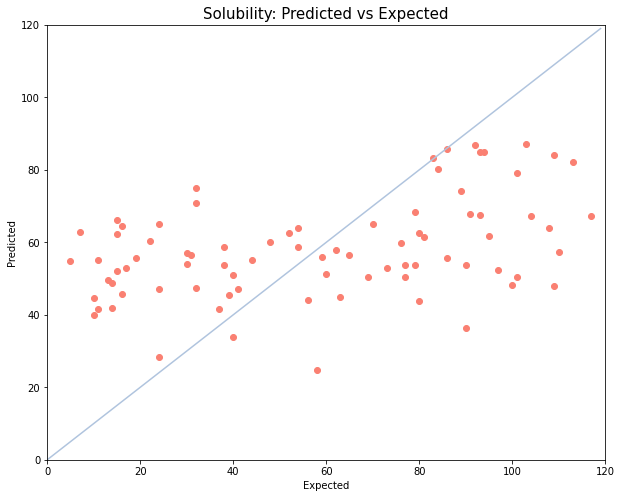

In [9]:
# Plot the R2 predicted and expected results
plot_pred_expected_results(y_test, y_pred)

# Saving trained model

In [10]:
filename = '../models/mlpRegressor_model.joblib'
joblib.dump(mlp_best, filename)

['../models/mlpRegressor_model.joblib']